## 介绍：特征选择

上一节课我们学习了如何从原始数据中加工出样本粒度的特征，从121维提高到了295维。

当我们有这么多特征的时候，里面必然会有相关性共线性很强的问题，甚至有些特征的缺失率也会很高，所以我们需要进一步筛选。

特征筛选的方法有很多，本次主要采用下面三个步骤
1. 删除相关性强特征
2. 删除缺失率高的特征
3. 通过计算特征IV值等重要性指标来进一步筛选

    其中特征IV值的计算公式为：
$IV=\sum ^{n}_{i=1}IV_{i}=\sum ^{n}_{i=1}\left( pm_{i}-pn_{i}\right) \ln 
\dfrac {pm_{i}}{pn_{i}}$

    * $pm_i$是这个分组中响应客户（即取值为1）在所有响应客户的占比
    * $pn_i$是这个分组中未响应客户（即取值为0）在所有未响应客户的占比


通过先建模利用模型输出的特征重要性来进行特征选择的方法也被广泛使用，这类方法我们放在后面的算法部分讲。


---
## python实现

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 读取上次加工完成的特征
data_path = './data/featured_data.csv'

data = pd.read_csv(data_path)
data = data.set_index('SK_ID_CURR')
data.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,...,MEAN_STATUS_ABOVE,STD_STATUS_2MON,STD_STATUS_4MON,STD_STATUS_12MON,STD_STATUS_24MON,STD_STATUS_36MON,STD_STATUS_ABOVE,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,1.0,0.0247,...,0.5,NaN,NaN,NaN,0.506623,0.474579,0.534523,0.0,45.0,72.0
100003,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 根据目标变量的有无选出训练集和测试集
train = data[~data['TARGET'].isnull()]
test = data[data['TARGET'].isnull()]

print("【INFO】训练集行列数为：{0}，测试集行列数为：{1}".format(train.shape, test.shape))

【INFO】训练集行列数为：(10000, 295)，测试集行列数为：(1000, 295)


In [4]:
#  将标签列放到第一列
train_label = train.pop('TARGET')
train.insert(0,'TARGET',train_label)

### 1. 删除相关性强特征

In [5]:
# 定义阈值
threshold = 0.9

# 计算变量相关性矩阵
corr_matrix = train.corr().abs()
corr_matrix.head()

,TARGET,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MEAN_STATUS_ABOVE,STD_STATUS_2MON,STD_STATUS_4MON,STD_STATUS_12MON,STD_STATUS_24MON,STD_STATUS_36MON,STD_STATUS_ABOVE,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE
TARGET,1.000000,0.015849,0.044034,0.051565,0.024181,0.010797,0.014910,0.001430,0.007225,0.013847,...,0.062283,0.037154,0.010759,0.030856,0.022769,0.032427,0.046541,0.061740,0.093987,0.032498
AMT_ANNUITY,0.015849,1.000000,0.785932,0.788675,0.458479,0.017482,0.037620,0.005424,0.040706,0.006717,...,0.020489,0.010579,0.024906,0.016629,0.017434,0.033770,0.004390,0.003926,0.036367,0.028068
AMT_CREDIT,0.044034,0.785932,1.000000,0.986840,0.391627,0.014079,0.067103,0.009823,0.014626,0.027871,...,0.030487,0.020689,0.028213,0.026620,0.006071,0.040396,0.014502,0.002135,0.108070,0.056145
AMT_GOODS_PRICE,0.051565,0.788675,0.986840,1.000000,0.397080,0.016740,0.068098,0.009754,0.018075,0.031405,...,0.036289,0.023210,0.028046,0.026816,0.003945,0.041934,0.019073,0.002428,0.105355,0.058961
AMT_INCOME_TOTAL,0.024181,0.458479,0.391627,0.397080,1.000000,0.038520,0.080579,0.007084,0.025735,0.032323,...,0.024569,0.004671,0.017145,0.010470,0.019542,0.022810,0.005217,0.076202,0.077385,0.153826


In [6]:
# 对角化相关矩阵
corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_matrix_upper.head()

,TARGET,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,MEAN_STATUS_ABOVE,STD_STATUS_2MON,STD_STATUS_4MON,STD_STATUS_12MON,STD_STATUS_24MON,STD_STATUS_36MON,STD_STATUS_ABOVE,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE
TARGET,NaN,0.015849,0.044034,0.051565,0.024181,0.010797,0.014910,0.001430,0.007225,0.013847,...,0.062283,0.037154,0.010759,0.030856,0.022769,0.032427,0.046541,0.061740,0.093987,0.032498
AMT_ANNUITY,NaN,NaN,0.785932,0.788675,0.458479,0.017482,0.037620,0.005424,0.040706,0.006717,...,0.020489,0.010579,0.024906,0.016629,0.017434,0.033770,0.004390,0.003926,0.036367,0.028068
AMT_CREDIT,NaN,NaN,NaN,0.986840,0.391627,0.014079,0.067103,0.009823,0.014626,0.027871,...,0.030487,0.020689,0.028213,0.026620,0.006071,0.040396,0.014502,0.002135,0.108070,0.056145
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,0.397080,0.016740,0.068098,0.009754,0.018075,0.031405,...,0.036289,0.023210,0.028046,0.026816,0.003945,0.041934,0.019073,0.002428,0.105355,0.058961
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,NaN,0.038520,0.080579,0.007084,0.025735,0.032323,...,0.024569,0.004671,0.017145,0.010470,0.019542,0.022810,0.005217,0.076202,0.077385,0.153826


In [7]:
# 选择相关性有大于某值的变量删除
to_drop = [column for column in corr_matrix_upper.columns if any(corr_matrix_upper[column] > threshold)]

train = train.drop(columns = to_drop,axis=1)
test = test.drop(columns = to_drop,axis=1)

print('【INFO】有{0}个特征移除,现有特征维度数为{1}' .format (len(to_drop),train.shape[1]))

【INFO】有62个特征移除,现有特征维度数为233


### 2. 删除缺失率高的特征

In [8]:
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head(10)

DEF_30B60_PERC       0.8836
MEAN_STATUS_36MON    0.8147
AMAX_STATUS_36MON    0.8147
MEAN_STATUS_2MON     0.8139
AMAX_STATUS_2MON     0.8139
MEAN_STATUS_4MON     0.8117
AMAX_STATUS_4MON     0.8117
MEAN_STATUS_ABOVE    0.7971
AMAX_STATUS_ABOVE    0.7971
MEAN_STATUS_24MON    0.7863
dtype: float64

In [9]:
# 根据缺失率删除缺失率高的特征
to_drop = train_missing.index[train_missing > 0.75]

train = train.drop(columns = to_drop,axis=1)
test = test.drop(columns = to_drop,axis=1)

print('【INFO】有{0}个特征移除,现有特征维度数为{1}' .format (len(to_drop),train.shape[1]))

【INFO】有13个特征移除,现有特征维度数为220


### 3. 通过计算特征重要性指标来进一步筛选

特征与目标变量的相关系数

In [10]:
# 计算特征与目标变量的相关性
# 由于目标变量取值0 1，计算特征重要性更多使用是IV这里是给大家演示下
feature_corr = data.corr().abs()['TARGET'].reset_index(name='importance').rename(columns={'index':'feature'})
feature_corr = feature_corr[feature_corr['feature']!= 'TARGET']

In [11]:
# 绘制水平方向的直方图
def plot_feature_importances(df, num):
    df = df.copy()
    # 按照特征重要性排序
    df = df.sort_values('importance', ascending = False).reset_index(drop=True)

    # 声明画板和子图
    plt.figure(figsize = (10, num*1/3))
    ax = plt.subplot()
    
    # 绘制水平直方图
    ax.barh(list(reversed(list(df.index[: num]))), 
            df['importance'].head(num), 
            align = 'center', edgecolor = 'k')
    
    # 设置y坐标名称
    ax.set_yticks(list(reversed(list(df.index[: num]))))
    ax.set_yticklabels(df['feature'].head(num))
    
    # 添加坐标轴和标题名
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return df

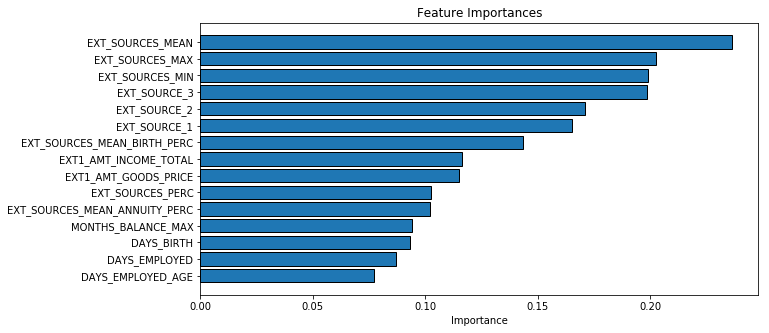

In [12]:
feature_importances = plot_feature_importances(feature_corr,15)

### 计算IV值

变量分箱：将所有变量分段转化为成5个以下的离散取值，本次采用的分割方式为等频切分的方式。

数据离散化的方法还有基于决策树的tree切割以及基于卡方的chimerge切割，感兴趣的同学可以自行查阅。

In [13]:
# pd.qcut(data['DAYS_BIRTH'],5)
# pd.qcut(data['DAYS_BIRTH'],5,labels=[1,2,3,4,5])

In [14]:
# 等频分箱
def cut_feature(df):
    df = df.copy()
    uncut_feat = []
    cut_feat = []
    for feat in df.columns.tolist():
        if feat == 'TARGET':
            continue
        if df[feat].dtype == 'object' or df[feat].unique().shape[0]<=5:
            df[feat],_ = pd.factorize(df[feat])
        else:
            try:
                df[feat] = pd.qcut(df[feat],5,labels=[1,2,3,4,5])
                df[feat],_ = pd.factorize(df[feat])
            except ValueError:
                uncut_feat.append(feat)
            else:
                cut_feat.append(feat)
    return df,uncut_feat,cut_feat

df,uncut_feat,cut_feat = cut_feature(train)

In [15]:
def IV(x, y): 
    num_0 = np.sum(y==0)
    num_1 = np.sum(y==1)
    num_0_group = np.zeros(np.unique(x).shape)
    num_1_group = np.zeros(np.unique(x).shape)
    for i in range(len(np.unique(x))):
        num_0_group[i] = y[(x == np.unique(x)[i]) & (y == 0)].count()
        num_1_group[i] = y[(x == np.unique(x)[i]) & (y == 1)].count()
    iv = np.sum((num_0_group/num_0 - num_1_group/num_1) * np.log((num_0_group/num_0)/(num_1_group/num_1)))
    return  iv   
   
def df_iv(df,Y):
    df = df.copy()
    X = df.drop([Y], axis=1)
    iv_list = []
    for col in X.columns:
        iv = IV(df[col], df[Y])
        iv_list.append(iv)
    names = list(X.columns)
    iv_df = pd.DataFrame({'feature': names, 'IV': iv_list})
    return iv_df

In [16]:
df = df[cut_feat+['TARGET']]
iv_df = df_iv(df,'TARGET')

iv_df.sort_values('IV',ascending=False).reset_index(drop=True)[:15]

,feature,IV
0,EXT_SOURCES_MEAN,0.671039
1,EXT_SOURCES_MIN,0.520590
2,EXT_SOURCES_MAX,0.471198
3,EXT_SOURCE_3,0.410280
4,EXT_SOURCE_2,0.330366
5,EXT1_AMT_INCOME_TOTAL,0.283908
6,EXT_SOURCES_MEAN_BIRTH_PERC,0.273185
7,EXT_SOURCES_MEAN_ANNUITY_PERC,0.243921
8,EXT_SOURCES_PERC,0.202089
9,EXT_SOURCE_1,0.160808


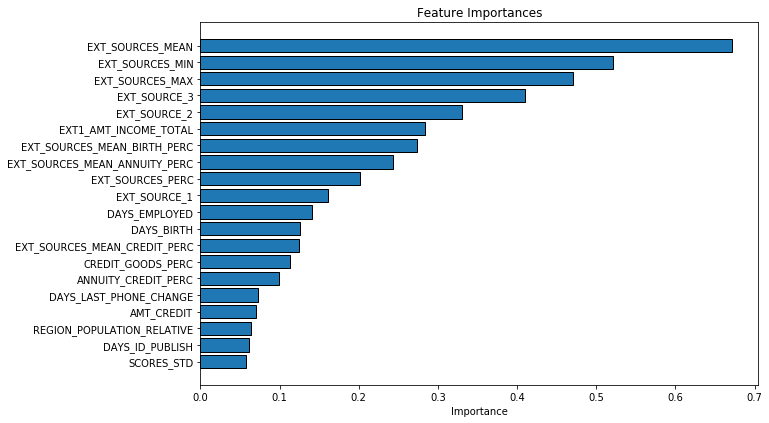

In [17]:
# 绘制水平直方图
feature_importances = plot_feature_importances(iv_df.rename(columns={'IV':'importance'}),20)

#### 通过IV值筛选

In [18]:
# 根据缺失率删除缺失率高的特征

to_drop = iv_df[iv_df['IV'] < 0.03].feature

train = train.drop(columns = to_drop,axis=1)
test = test.drop(columns = to_drop,axis=1)

print('【INFO】有{0}个特征移除,现有特征维度数为{1}' .format (len(to_drop),train.shape[1]))

【INFO】有19个特征移除,现有特征维度数为201
